# Comparing meta-learners with different ensembles of trees as base learners

## Introduction

Meta-learners are a class of models used for estimating *heterogeneous causal effect* of a certain treatement. Here by heterogeneity, we mean that the effect of the treatement may vary across individuals. They approach this problem by decomposing it to several subregressions. The models used for these subregressions are called *base learners*. Some of the most popular base learners are tree based ensembles, in particular Random Forest and Bayesian Additive Regression Trees (BART) due to their flexibility, however any machine learning algorithm suitable for regression problems (like generalized linear regressions, gaussian processes, etc.) can be used.

We will denote by $Y$ a $d$-dimensional outcome vector, by $X \in \mathbb{R}^{d \times n}$ a feature matrix containing potential confounders, by $W \in \{0, 1\}^d$ the treatment assignment indicator and by  $Y(0) \in \mathbb{R}^d$ and $Y(1) \in \mathbb{R}^d$ the potential outcome of corresponding units when assigned to the control and the treatement group respectively. Note that in general, we only observe one of the potential outcomes, furthermore
$$ Y = W Y(1) + (1 - W) Y(0).$$

Our task is to estimate the *conditional average treatement effect (CATE)*, defined as 
$$\tau(x) = \mathbb{E}\left[Y(1) - Y(0) \mid X=x\right].$$

## Data generation

In this notebook we will deal with synthetic data, so that we can quantify exactly the mean squared error of our CATE estimations. The data generating is of the form
$$y = \operatorname{sinc}(\alpha X) + W \sigma(\beta X) + \varepsilon,$$
where $\varepsilon_i \sim N(0, 1)$ and $W_i \sim \operatorname{Bernoulli}\left(\frac14\right)$ are i.i.d., $$\sigma(x) = \frac{e^x}{1 + e^x}, \quad \text{and} \quad \operatorname{sinc}(x) = \frac{\sin(x)}{x}$$ are applied coordinate-wise.

Here, CATE can be expressed as $$\tau(X) = \sigma(\beta X).$$

In [1]:
import numpy as np
import pandas as pd
from causalpy.skl_meta_learners import SLearner, TLearner, XLearner, DRLearner
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(42)

def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

def sinc(x):
    return np.where(x==0, 1, np.sin(x) / x)

def create_synthetic_data(*shape):
    X = np.random.rand(*shape)

    α = np.random.rand(shape[1])
    β = np.random.rand(shape[1])

    treatment = np.random.binomial(n=1, p=.25, size=shape[0])
    treatment_effect = sigmoid(X @ β)

    noise = np.random.rand(shape[0])

    y = sinc(X @ α) + treatment_effect * treatment + noise

    X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(shape[1])])
    y = pd.Series(y, name='target')
    treated = pd.Series(treatment, name='treatment')
    return X, y, treated, treatment_effect

X, y, treated, treatment_effect = create_synthetic_data(500, 20)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Summary
The summary method of a scikit-learn based meta-learner contains
* Number of observations,
* number of treated observations,
* average treatement effect (ATE),
* 95% Confidence interval for ATE,
* estimated bias.

Confidence intervals and bias are calculated when summary is called via bootstrapping. This means that the runtime of each learner in these examples will be exaggerated. 

In [11]:
def summarize_learner(learner):
    learner.summary(n_iter=100)
    print(f"Actual average treatement effect: {treatment_effect.mean()}")
    print(f"MSE: {mean_squared_error(treatment_effect, learner.cate)}")

## S-learner

The simplest meta-learner is the *S-learner*, which predicts the potential outcome vectors by treating the treatement assignment indicator as a feature and estimates

$$\mu(x, w) := \mathbb{E}[Y \mid X=x, W=w]$$

with an appropriate base learner. The "S" in S-learner stands for "single", as it uses a single model to estimate CATE. We will denote this estimation with $\hat{\mu}(x, w)$. Then the S-learner approximates CATE as  

$$\hat{\tau_S}(x) = \hat{\mu}(x, 1) - \hat{\mu}(x, 0).$$

In the following example we will choose `HistGradientBoostingRegressor` as base learner.

In [2]:
%%time
# Utility for printing some statistics.
slearner = SLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor()
)

summarize_learner(slearner)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.0158653426134698
95% Confidence interval for ATE:    (0.7168756519845457, 1.4142990694909983)
Estimated bias:                     -0.0032205093538485788
Actual average treatement effect: 0.9935910373038435
MSE: 0.04298096898757659
CPU times: total: 6min 23s
Wall time: 55.9 s


## T-learner

The *T-learner* is a closely related meta-learner. Here, instead of including the treatment assignment indicator as a feature, we estimate the potential outcomes in two different regressions. Namely, we estimate
$$\mu_{\operatorname{treated}}(x) := \mathbb{E}[Y(1) \mid X=x], \quad \text{and} \quad \mu_{\operatorname{untreated}}(x) := \mathbb{E}[Y(0) \mid X=x]$$
separately and define estimate the cate as
$$\hat{\tau}_T(x) = \hat{\mu}_{\operatorname{treated}}(x) - \hat{\mu}_{\operatorname{untreated}}(x),$$
where $\hat{\mu}_{\operatorname{treated}}$ and $\hat{\mu}_{\operatorname{untreated}}$ are the estimated functions. 

If we choose our base-learners to be a forest based ensemble, in the case of the S-learner, during the fitting process splits on the treatement assignment indicator can happen *anywhere* in the trees. In the fitting process of the T-learner however, we essentially force a split at the first level. This difference means that the S-learner is more flexible, but especially when using regularization, it is prone to disregard the effect of the treatment. On the other hand the T-learner uses two separate models that do not share information between each other, which may lead to overfitting if one of the treatement groups is small.

In [3]:
%%time
tlearner = TLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor()
)

summarize_learner(tlearner)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.0602041004116796
95% Confidence interval for ATE:    (0.6678309683577215, 1.5429661284355667)
Estimated bias:                     0.009071047889501997
Actual average treatement effect: 0.9935910373038435
MSE: 0.08202638716051415
CPU times: total: 6min 32s
Wall time: 55.4 s


# X-learner
Similarly, to the T-learner, the X-learner first estimates $\mu_{\operatorname{treated}}$ and $\mu_{\operatorname{untreated}}$. Next, it computes 

$$D(1) := Y(1) - \hat{\mu}_{\operatorname{untreated}}(X(1)), \quad \text{and} \quad D(0) = \hat{\mu}_{\operatorname{treated}}(X(0)) - Y(0).$$

Note that if $\hat{\mu}_{\operatorname{untreated}} = \mu_{\operatorname{untreated}}$ and $\hat{\mu}_{\operatorname{treated}} = \mu_{\operatorname{treated}}$, then $\tau(x) = \mathbb{E}[D(1) | X=x] = \mathbb{E}[D(0) | X=x]$, so CATE may be estimated by regressing on $D(0)$ or $D(1)$. Let us denote the estimations obtained this way by $\tau_0$ and $\tau_1$, respectively. 

Finally, the X-learner computes a weighted average of the two CATE estimates, that is 
$$\hat{\tau}_X(x) = g(x)\hat{\tau}_0 + (1 - g(x))\hat{\tau_1}(x),$$
for some weight function $g: \mathbb{R}^d \rightarrow [0, 1]$.

In CausalPy, we obtain $g$ as an estimation of the so-called *propensity score*, that is the conditional probability of a unit receiving treatment given $X$. By default, we use logistic regression to obtain this estimation. However, in case one of the treatement groups is small, it makes sense to set $g \equiv 0$ or $g \equiv 1$.

In [4]:
%%time
# Using logistic regression based propensity score
xlearner = XLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor()
)

summarize_learner(xlearner)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.0241946147950118
95% Confidence interval for ATE:    (0.7780033378922033, 1.3792194001196363)
Estimated bias:                     -0.0030826969031921064
Actual average treatement effect: 0.9935910373038435
MSE: 0.04195048793085756
CPU times: total: 13min 10s
Wall time: 1min 52s


In [5]:
%%time
# Using constant g
xlearner_mf = XLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(strategy="most_frequent")
)

summarize_learner(xlearner_mf)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.036517292248574
95% Confidence interval for ATE:    (0.7821662021543369, 1.3970869383992666)
Estimated bias:                     0.0016462894459864125
Actual average treatement effect: 0.9935910373038435
MSE: 0.04195048793085756
CPU times: total: 13min 5s
Wall time: 1min 48s


For a deeper dive on the aforementioned three estimators I suggest reading [1] or for a lighter overview in video format, check out [Causal Effects via Regression by Shawhin Talebi](https://youtu.be/O72uByJlnMw).

# DR-learner

The *doubly-robust learner*, also known as the *DR-learner*, takes its name from the property that it is unbiased if either the propensity score estimator or the outcome regressions are correctly specified.

The DR-learner first splits the set of observations $S = (Y, X, W)$ randomly into two parts $S_i = (Y_i, X_i, W_i), i=1,2$ of equally many observations, finds the estimates $\hat{\mu}_{\operatorname{treated}}$, $\hat{\mu}_{\operatorname{untreated}}$ and $g$ on $S_1$. Then it constructs 

$$\varphi(X) = \frac{W - g(X)}{g(X)(1 - g(X))}(Y - \hat{\mu}_{W}(X)) + \hat{\mu}_{\operatorname{treated}} - \hat{\mu}_{\operatorname{untreated}}$$
called the *pseudo-outcome*, where $\hat{\mu}_W(X) = (1 - W)\hat{\mu}_{\operatorname{untreated}} + W\hat{\mu}_{\operatorname{treated}}$. Finally, regressing $\varphi(X_2)$ on $X_2$ yields the CATE estimator $\hat{\tau}_{DR}$. Optionally, one may perform a *cross-fitting step* by swapping the roles of $S_1$ and $S_2$ obtaining a second estimator. Averaging the two estimators usually results in a better one.

In [9]:
%%time
drlearner = DRLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier()
)

summarize_learner(drlearner)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.043603596223281
95% Confidence interval for ATE:    (0.5722356606341764, 1.791826637224789)
Estimated bias:                     0.06476430795642821
Actual average treatement effect: 0.9935910373038435
MSE: 0.26413051181872693
CPU times: total: 7min 7s
Wall time: 58.8 s


In [2]:
%%time
drlearner = DRLearner(
    X=X,
    y=y,
    treated=treated,
    model=HistGradientBoostingRegressor(),
    propensity_score_model=DummyClassifier(),
    cross_fitting=True
)

summarize_learner(drlearner)

Number of observations:             500
Number of treated observations:     126
Average treatement effect (ATE):    1.0124610535982221
95% Confidence interval for ATE:    (0.5464324003175869, 1.6467470784122396)
Estimated bias:                     -0.012888295172939901
Actual average treatement effect: 0.9935910373038435
MSE: 0.11390230987800598
CPU times: total: 14min 6s
Wall time: 1min 56s


In [10]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

def compute_mse(learner, m):
    l = learner(X, y, treated, m)
    return mean_squared_error(treatment_effect, l.cate)

models = [
    ("Random forest", RandomForestRegressor()),
    ("Hist gradient boosting", HistGradientBoostingRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("XGBoost", XGBRegressor()),
    ("SVR", SVR())
]

learners = [
    ("S-learner", SLearner),
    ("T-learner", TLearner),
    ("X-learner", XLearner),
    ("DR-learner", DRLearner),
    ("Cross-fitted DR-learner", lambda *args: DRLearner(*args, cross_fitting=True))
]
bench = pd.DataFrame({
    m_name: {
        learner_name:  compute_mse(learner, m) for learner_name, learner in learners
    } for m_name, m in models
})

<AxesSubplot:>

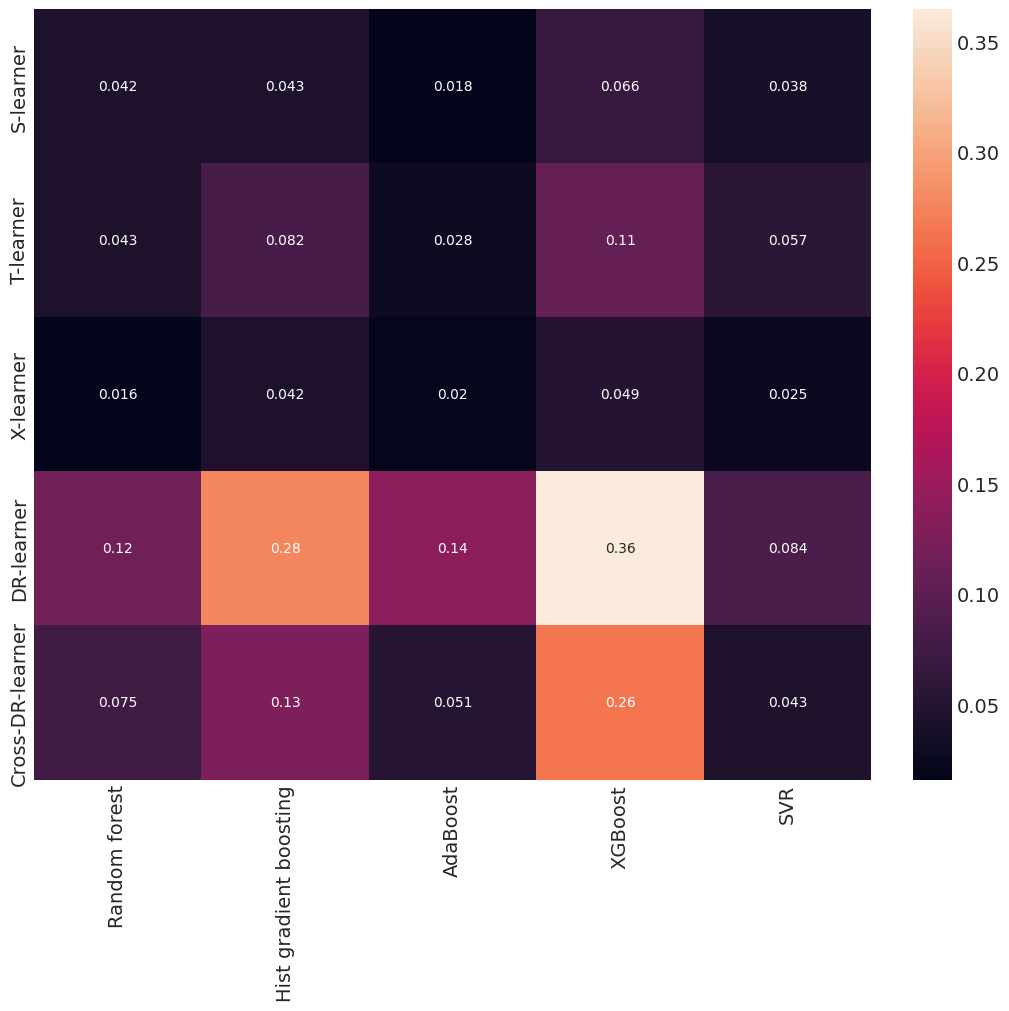

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(bench, annot=True, ax=ax)